In [1]:
import os
from glob import glob
import pickle

import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = glob('../src/data/SeaFog/*.csv')

In [3]:
data_dir.sort()

In [4]:
data_dir

['../src/data/SeaFog/302_증산도.csv',
 '../src/data/SeaFog/771_불무기도.csv',
 '../src/data/SeaFog/772_장도.csv',
 '../src/data/SeaFog/789_목포구.csv',
 '../src/data/SeaFog/SF_0008_여수 해무관측소.csv']

In [5]:
col_list = ['지점 기온(°C)',
'수온(°C)',
'강수량 1분(mm)',
'풍속(m/s)',
'u',
'v',
"현지기압(hPa)",
'해면기압(hPa)',
'습도(%)',
'일사(MJ/m^2)',
'일조(Sec)',
'T',
'해기차(T-SST)',
'이슬점온도(°C)',
'기온',
'이슬점온도(T-Td)',
'수온',
'이슬점온도(°C)',
'vis']


In [6]:
col = ['기온(°C)',
 '수온(°C)',
 '풍속(m/s)',
 'u',
 'v',
 '습도(%)',
 '해기차(T-SST)',
 '이슬점온도(°C)',
 '기온-이슬점온도(T-Td)',
 '수온-이슬점온도(°C)',
 'vis']

In [7]:
new_col = ['t', 'st', 'ws', 'u', 'v', 'h', 'astd', 
          'dp', 't-dp', 'st-dp', 'vis']

In [8]:
temp_1 = []
temp_2 = []
target_col_name = []

for ii, _dir in enumerate(data_dir):
    data = pd.read_csv(_dir, index_col=0, encoding='cp949')
    island_name = data['지점'][0]
    data = data[data.index >= '2019-12-14 09:00:00']
    data.drop('지점', axis=1, inplace=True)
    data.drop('해면기압(hPa)', axis=1, inplace=True)
    
    if ii < len(data_dir)-1:
        data.drop('일사(MJ/m^2)', axis=1, inplace=True)
        data.drop('일조(Sec)', axis=1, inplace=True)
        data.drop('1분 강수량(mm)', axis=1, inplace=True)
        data.drop('현지기압(hPa)', axis=1, inplace=True)
        data.drop('T', axis=1, inplace=True)
        
    df_1 = data[data.index <= '2021-06-01 23:50:00']
    df_2 = data[data.index >= '2021-07-01 00:00:00']


    col_name_change = {col[i]:str(island_name)+'_'+new_col[i] for i in range(len(new_col))}
    
    df_1.rename(columns=col_name_change, inplace=True)
    df_2.rename(columns=col_name_change, inplace=True)
    

    target_col_name.append(str(island_name)+'_vis')
        
    temp_1.append(df_1)
    temp_2.append(df_2)

/opt/anaconda3/envs/GraphStructureLearning/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [9]:
dataframe_1 = pd.DataFrame()

for df in temp_1:
    dataframe_1 = pd.concat([dataframe_1, df], axis=1)
    
dataframe_2 = pd.DataFrame()

for df in temp_2:
    dataframe_2 = pd.concat([dataframe_2, df], axis=1)

In [10]:
dataframe_1.dropna(inplace=True)
dataframe_2.dropna(inplace=True)

In [11]:
dataframe_1.index = pd.to_datetime(dataframe_1.index)
dataframe_2.index = pd.to_datetime(dataframe_2.index)

In [12]:
for _col in target_col_name:
    dataframe_1.loc[dataframe_1[_col] >= 3000 , _col] = 3000
    dataframe_2.loc[dataframe_2[_col] >= 3000 , _col] = 3000

In [ ]:
for _col in target_col_name:
    plt.plot(dataframe_1[_col])
    plt.show()

In [ ]:
for _col in target_col_name:
    plt.plot(dataframe_2[_col][144:144*4])
    plt.show()

In [13]:
num_timesteps_in = 6*20
num_timesteps_out = 6

In [14]:
df = pd.concat([dataframe_1, dataframe_2], axis=0)

In [15]:
indices = [
    (i, i + (num_timesteps_in + num_timesteps_out))
    for i in range(df.shape[0] - (num_timesteps_in + num_timesteps_out))
    if (df.index[i + (num_timesteps_in + num_timesteps_out)] - df.index[i]).seconds / 600 == num_timesteps_in + num_timesteps_out
]

In [17]:
len(indices)

35440

In [18]:
import random

In [19]:
random.shuffle(indices)

In [20]:
col_names = df.columns
index_val = df.index

In [22]:
import sys

sys.path.append('../src')

In [23]:
from utils.scalers import Scaler

In [24]:
scaler = Scaler('std')

In [25]:
scaled_df = scaler.scale(df.to_numpy().T)

In [26]:
scaled_df = pd.DataFrame(scaled_df.T, columns = list(col_names), index=index_val)

In [27]:
scaled_df

,302_t,302_st,302_ws,302_u,302_v,302_h,302_astd,302_dp,302_t-dp,302_st-dp,...,SF_0008_st,SF_0008_ws,SF_0008_u,SF_0008_v,SF_0008_h,SF_0008_astd,SF_0008_dp,SF_0008_t-dp,SF_0008_st-dp,SF_0008_vis
time,,,,,,,,,,,,,,,,,,,,,
2019-12-14 09:10:00,-0.825823,-0.684769,1.109198,0.402242,1.366727,-0.574049,-0.535403,-0.866709,0.462581,0.768693,...,-0.688982,-0.373554,-0.810470,-0.194980,-0.352511,-0.602252,-0.679141,0.226214,0.491964,0.076947
2019-12-14 09:20:00,-0.819658,-0.696716,1.144412,0.457001,1.382720,-0.693561,-0.502461,-0.917097,0.592307,0.848454,...,-0.688982,-0.483082,-0.725774,-0.148008,-0.493892,-0.546617,-0.727112,0.374868,0.575258,0.076947
2019-12-14 09:30:00,-0.809795,-0.704183,0.956602,0.911414,1.132977,-0.738856,-0.469519,-0.930396,0.642180,0.864076,...,-0.688982,-0.675065,-0.026357,-0.260200,-0.510956,-0.514407,-0.725338,0.393364,0.572177,0.076947
2019-12-14 09:40:00,-0.811028,-0.714637,1.196581,0.493888,1.425736,-0.681555,-0.454315,-0.904484,0.579146,0.802169,...,-0.688982,0.412835,0.762134,0.809099,-0.586521,-0.531976,-0.766251,0.474621,0.643216,0.076947
2019-12-14 09:50:00,-0.797466,-0.717623,1.097459,0.613026,1.339716,-0.669004,-0.421373,-0.887802,0.565812,0.767023,...,-0.688982,0.850949,0.502845,1.472110,-0.659650,-0.587611,-0.818054,0.554126,0.733164,0.076947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 23:10:00,1.218298,1.152063,-0.704339,0.378541,-0.810470,1.017268,0.549150,1.398165,-0.962448,-1.180391,...,1.020009,-0.876892,-0.028765,-0.637827,1.353815,0.633431,1.302334,-1.194605,-1.243841,0.076947
2022-06-30 23:20:00,1.202270,1.152063,-1.121041,0.075661,-0.515276,1.052740,0.516208,1.396612,-0.989234,-1.177470,...,1.020165,-1.226399,-0.067061,-0.329883,1.353815,0.653635,1.308611,-1.194605,-1.254583,0.076947
2022-06-30 23:30:00,1.210900,1.152063,-0.804112,0.414350,-0.734867,1.038005,0.533946,1.398864,-0.978128,-1.181707,...,1.022194,-1.241167,-0.033113,-0.317284,1.353815,0.659264,1.311500,-1.194605,-1.257576,0.076947


In [28]:
col_names

Index(['302_t', '302_st', '302_ws', '302_u', '302_v', '302_h', '302_astd',
       '302_dp', '302_t-dp', '302_st-dp', '302_vis', '771_t', '771_st',
       '771_ws', '771_u', '771_v', '771_h', '771_astd', '771_dp', '771_t-dp',
       '771_st-dp', '771_vis', '772_t', '772_st', '772_ws', '772_u', '772_v',
       '772_h', '772_astd', '772_dp', '772_t-dp', '772_st-dp', '772_vis',
       '789_t', '789_st', '789_ws', '789_u', '789_v', '789_h', '789_astd',
       '789_dp', '789_t-dp', '789_st-dp', '789_vis', 'SF_0008_t', 'SF_0008_st',
       'SF_0008_ws', 'SF_0008_u', 'SF_0008_v', 'SF_0008_h', 'SF_0008_astd',
       'SF_0008_dp', 'SF_0008_t-dp', 'SF_0008_st-dp', 'SF_0008_vis'],
      dtype='object')

In [32]:
arr = scaled_df.to_numpy()

In [33]:
arr.shape

(96391, 55)

In [35]:
arr[:, 10].shape

(96391,)

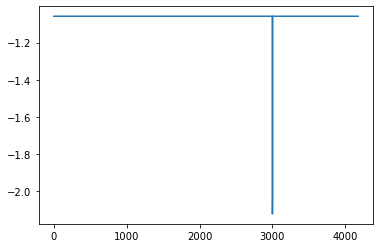

In [40]:
plt.plot(arr[:, 10][144:144*30])